In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster, TrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.trend import ProphetPiecewiseLinearTrendForecaster
from sktime.forecasting.compose import make_reduction

from sktime.split import ExpandingGreedySplitter
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.transformations.compose import Id, YtoX
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.pipeline import Pipeline

from sktime.transformations.series.difference import Differencer

import warnings

In [2]:
data = pd.read_csv(
    "../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv", index_col=None
)

data.index = pd.to_datetime(data["Timestamp"], utc=True)
data.index = data.index.tz_localize(None)
data["y"] = data["NE7_GWh"].values
data = data.drop(columns=["Timestamp", "NE5_GWh", "NE7_GWh"])
data.index = pd.period_range(start=data.index[0], end=data.index[-1], freq="M")

# split data
# don't use stride (step_length=5).Keeps last splitt completely unseen. Test_size fixed by task
splitter = ExpandingGreedySplitter(test_size=12, folds=4)  # step_length=5,
splits = list(splitter.split(data))

In [3]:
y_train = data.iloc[splits[0][0]]
y_test = data.iloc[splits[0][1]]

In [18]:
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.pipeline import Pipeline
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.linear_model import Ridge
from unittest.mock import MagicMock, patch
import numpy as np
import pandas as pd

# Load the airline dataset
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y)

y_train = pd.Series(np.arange(100))

ridge = Ridge()
fit_mock = MagicMock()
forecaster = make_reduction(ridge, window_length=6, strategy="recursive")


kwargs = {
    "lag_feature": {
        "sum": [[0, 3]],  # [lag,window_length], if lag=0 includes most current
    }
}

with patch.object(Ridge, "fit", fit_mock):
    # Create a pipeline
    pipe = Pipeline()
    pipe = pipe.add_step(
        Differencer(lags=[1], na_handling="keep_na"), "differencer", edges={"X": "y"}
    )
    pipe = pipe.add_step(WindowSummarizer(**kwargs), "window", edges={"X": "y"})
    pipe = pipe.add_step(
        forecaster, name="forecaster", edges={"X": ["differencer", "window"], "y": "y"}
    )

    # Fit the pipeline
    pipe.fit(y=y_train)

fit_args = fit_mock.call_args
input_to_fit = fit_args[0]

C:\Users\ewzbusi\Desktop\repos\sktime\sktime\pipeline\pipeline.py:160: UserWarning: This generalised graphical pipeline is experimental, with all the usual risks of edge features. For mature alternatives, use single-purpose pipelines and compositors, such as TransformedTargetForecaster, ForecastingPipeline, ClassificationPipeline, etc., see for instance notebooks 01_forecasting.ipynb and 02_classification.ipynb athttps://github.com/sktime/sktime/blob/main/examples/.
  warnings.warn(
C:\Users\ewzbusi\Desktop\repos\sktime\sktime\pipeline\pipeline.py:160: UserWarning: This generalised graphical pipeline is experimental, with all the usual risks of edge features. For mature alternatives, use single-purpose pipelines and compositors, such as TransformedTargetForecaster, ForecastingPipeline, ClassificationPipeline, etc., see for instance notebooks 01_forecasting.ipynb and 02_classification.ipynb athttps://github.com/sktime/sktime/blob/main/examples/.
  warnings.warn(


In [21]:
np.set_printoptions(threshold=np.inf)

input_to_fit[0]

array([[  0.,   1.,   2.,   3.,   4.,   5.,  nan,   1.,   1.,   1.,   1.,
          1.,  nan,  nan,   3.,   6.,   9.,  12.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   1.,   1.,   1.,   1.,   1.,
          1.,  nan,   3.,   6.,   9.,  12.,  15.],
       [  2.,   3.,   4.,   5.,   6.,   7.,   1.,   1.,   1.,   1.,   1.,
          1.,   3.,   6.,   9.,  12.,  15.,  18.],
       [  3.,   4.,   5.,   6.,   7.,   8.,   1.,   1.,   1.,   1.,   1.,
          1.,   6.,   9.,  12.,  15.,  18.,  21.],
       [  4.,   5.,   6.,   7.,   8.,   9.,   1.,   1.,   1.,   1.,   1.,
          1.,   9.,  12.,  15.,  18.,  21.,  24.],
       [  5.,   6.,   7.,   8.,   9.,  10.,   1.,   1.,   1.,   1.,   1.,
          1.,  12.,  15.,  18.,  21.,  24.,  27.],
       [  6.,   7.,   8.,   9.,  10.,  11.,   1.,   1.,   1.,   1.,   1.,
          1.,  15.,  18.,  21.,  24.,  27.,  30.],
       [  7.,   8.,   9.,  10.,  11.,  12.,   1.,   1.,   1.,   1.,   1.,
          1.,  18.,  21.,  24.,  27.,  30.,  33.],


In [32]:
input_to_fit[0].shape
input_to_fit[1].shape

(24,)

In [33]:
fit_args[0][0][0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [5]:
idx = pd.period_range(start=y_test.index[0], end=y_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred = pipe.predict(fh=horizon)

<AxesSubplot:xlabel='Period'>

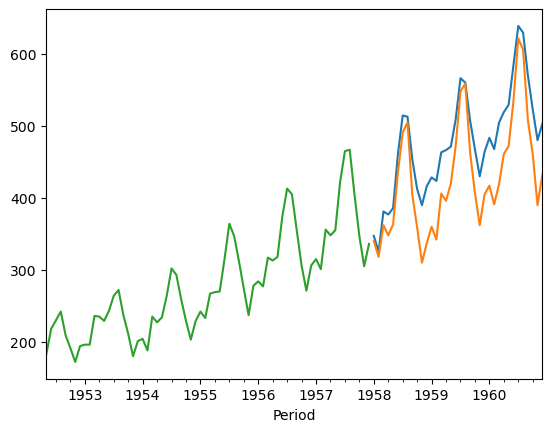

In [11]:
y_pred.plot()
y_test.plot()
y_train[40:].plot()